# A - Do a cobe lab with all hyperparameters learning rate decay, dropout, batch norm

Hint :https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist?hl=en#0

In [ ]:
BATCH_SIZE = 64
# EPOCHS = 10

training_images_file   = 'gs://mnist-public/train-images-idx3-ubyte'
training_labels_file   = 'gs://mnist-public/train-labels-idx1-ubyte'
validation_images_file = 'gs://mnist-public/t10k-images-idx3-ubyte'
validation_labels_file = 'gs://mnist-public/t10k-labels-idx1-ubyte'

In [ ]:
import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.8.0


In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

def read_label(tf_bytestring):
    label = tf.io.decode_raw(tf_bytestring, tf.uint8)
    label = tf.reshape(label, [])
    label = tf.one_hot(label, 10)
    return label
  
def read_image(tf_bytestring):
    image = tf.io.decode_raw(tf_bytestring, tf.uint8)
    image = tf.cast(image, tf.float32)/256.0
    image = tf.reshape(image, [28*28])
    return image
  
def load_dataset(image_file, label_file):
    imagedataset = tf.data.FixedLengthRecordDataset(image_file, 28*28, header_bytes=16)
    imagedataset = imagedataset.map(read_image, num_parallel_calls=16)
    labelsdataset = tf.data.FixedLengthRecordDataset(label_file, 1, header_bytes=8)
    labelsdataset = labelsdataset.map(read_label, num_parallel_calls=16)
    dataset = tf.data.Dataset.zip((imagedataset, labelsdataset))
    return dataset 
  
def get_training_dataset(image_file, label_file, batch_size):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache()  # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # Mandatory for Keras for now
    dataset = dataset.batch(batch_size, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
    dataset = dataset.prefetch(AUTO)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    return dataset
  
def get_validation_dataset(image_file, label_file):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache() # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

# instantiate the datasets
training_dataset = get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images_file, validation_labels_file)

# For TPU, we will need a function that returns the dataset
training_input_fn = lambda: get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_input_fn = lambda: get_validation_dataset(validation_images_file, validation_labels_file)

In [ ]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),
      
      tf.keras.layers.Conv2D(kernel_size=3, filters=12, use_bias=False, padding='same'),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=24, use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=32, use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Flatten(),
      
      tf.keras.layers.Dense(200, use_bias=False),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 12)        108       
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 12)       36        
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 28, 28, 12)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 24)        10368     
                                                                 
 batch_normalization_5 (Batc  (None, 14, 14, 24)       72        
 hNormalization)                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# lr decay function
def lr_decay(epoch):
  return 0.01 * math.pow(0.666, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

In [ ]:
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=1,
                    validation_data=validation_dataset, validation_steps=1)

Steps per epoch:  937
937/937 [==============================] - 92s 98ms/step - loss: 0.0572 - accuracy: 0.9829 - val_loss: 0.0530 - val_accuracy: 0.9854


# B - Do various experiments with weights and biases of hyperparameters in weights and biases of various optimizers, layer depth width, learning rate etc.,. both in keras and pytorch

reference: https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Organizing_Hyperparameter_Sweeps_in_PyTorch_with_W%26B.ipynb

In [ ]:
%%capture
!pip install wandb --upgrade

# workaround to fetch MNIST data
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

In [ ]:
import wandb

#wandb.login()

In [ ]:
sweep_config = {
    'method': 'random'
    }

In [ ]:
parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },
    'fc_layer_size': {
        'values': [128, 256, 512]
        },
    'dropout': {
          'values': [0.3, 0.4, 0.5]
        },
    }

sweep_config['parameters'] = parameters_dict

In [ ]:
parameters_dict.update({
    'epochs': {
        'value': 1}
    })

In [ ]:
import pprint

pprint.pprint(sweep_config)

{'method': 'random',
 'parameters': {'dropout': {'values': [0.3, 0.4, 0.5]},
                'epochs': {'value': 1},
                'fc_layer_size': {'values': [128, 256, 512]},
                'optimizer': {'values': ['adam', 'sgd']}}}


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="pytorch-sweeps-demo")

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: vsbjrb2p
Sweep URL: https://wandb.ai/weifeng/pytorch-sweeps-demo/sweeps/vsbjrb2p


In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        loader = build_dataset(config.batch_size)
        network = build_network(config.fc_layer_size, config.dropout)
        optimizer = build_optimizer(network, config.optimizer, config.learning_rate)

        for epoch in range(config.epochs):
            avg_loss = train_epoch(network, loader, optimizer)
            wandb.log({"loss": avg_loss, "epoch": epoch})  

In [ ]:
def build_dataset(batch_size):
   
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307,), (0.3081,))])
    # download MNIST training dataset
    dataset = datasets.MNIST(".", train=True, download=True,
                             transform=transform)
    sub_dataset = torch.utils.data.Subset(
        dataset, indices=range(0, len(dataset), 5))
    loader = torch.utils.data.DataLoader(sub_dataset, batch_size=batch_size)

    return loader


def build_network(fc_layer_size, dropout):
    network = nn.Sequential(  # fully-connected, single hidden layer
        nn.Flatten(),
        nn.Linear(784, fc_layer_size), nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(fc_layer_size, 10),
        nn.LogSoftmax(dim=1))

    return network.to(device)
        

def build_optimizer(network, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = optim.SGD(network.parameters(),
                              lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = optim.Adam(network.parameters(),
                               lr=learning_rate)
    return optimizer


def train_epoch(network, loader, optimizer):
    cumu_loss = 0
    for _, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # ➡ Forward pass
        loss = F.nll_loss(network(data), target)
        cumu_loss += loss.item()

        # ⬅ Backward pass + weight update
        loss.backward()
        optimizer.step()

        wandb.log({"batch loss": loss.item()})

    return cumu_loss / len(loader)

In [ ]:
wandb.agent(sweep_id, train, count=5)

wandb: Agent Starting Run: 4dte1wva with config:
wandb: 	dropout: 0.4
wandb: 	epochs: 1
wandb: 	fc_layer_size: 256
wandb: 	optimizer: sgd
wandb: Currently logged in as: weifeng (use `wandb login --relogin` to force relogin)


Run 4dte1wva errored: KeyError('batch_size')
wandb: ERROR Run 4dte1wva errored: KeyError('batch_size')
wandb: Agent Starting Run: 9m470ibr with config:
wandb: 	dropout: 0.5
wandb: 	epochs: 1
wandb: 	fc_layer_size: 128
wandb: 	optimizer: sgd


Run 9m470ibr errored: KeyError('batch_size')
wandb: ERROR Run 9m470ibr errored: KeyError('batch_size')
wandb: Agent Starting Run: jr5ahop1 with config:
wandb: 	dropout: 0.5
wandb: 	epochs: 1
wandb: 	fc_layer_size: 512
wandb: 	optimizer: sgd


Run jr5ahop1 errored: KeyError('batch_size')
wandb: ERROR Run jr5ahop1 errored: KeyError('batch_size')
Detected 3 failed runs in the first 60 seconds, killing sweep.
wandb: ERROR Detected 3 failed runs in the first 60 seconds, killing sweep.
wandb: To disable this check set WANDB_AGENT_DISABLE_FLAPPING=true


**Screenshot from my output**

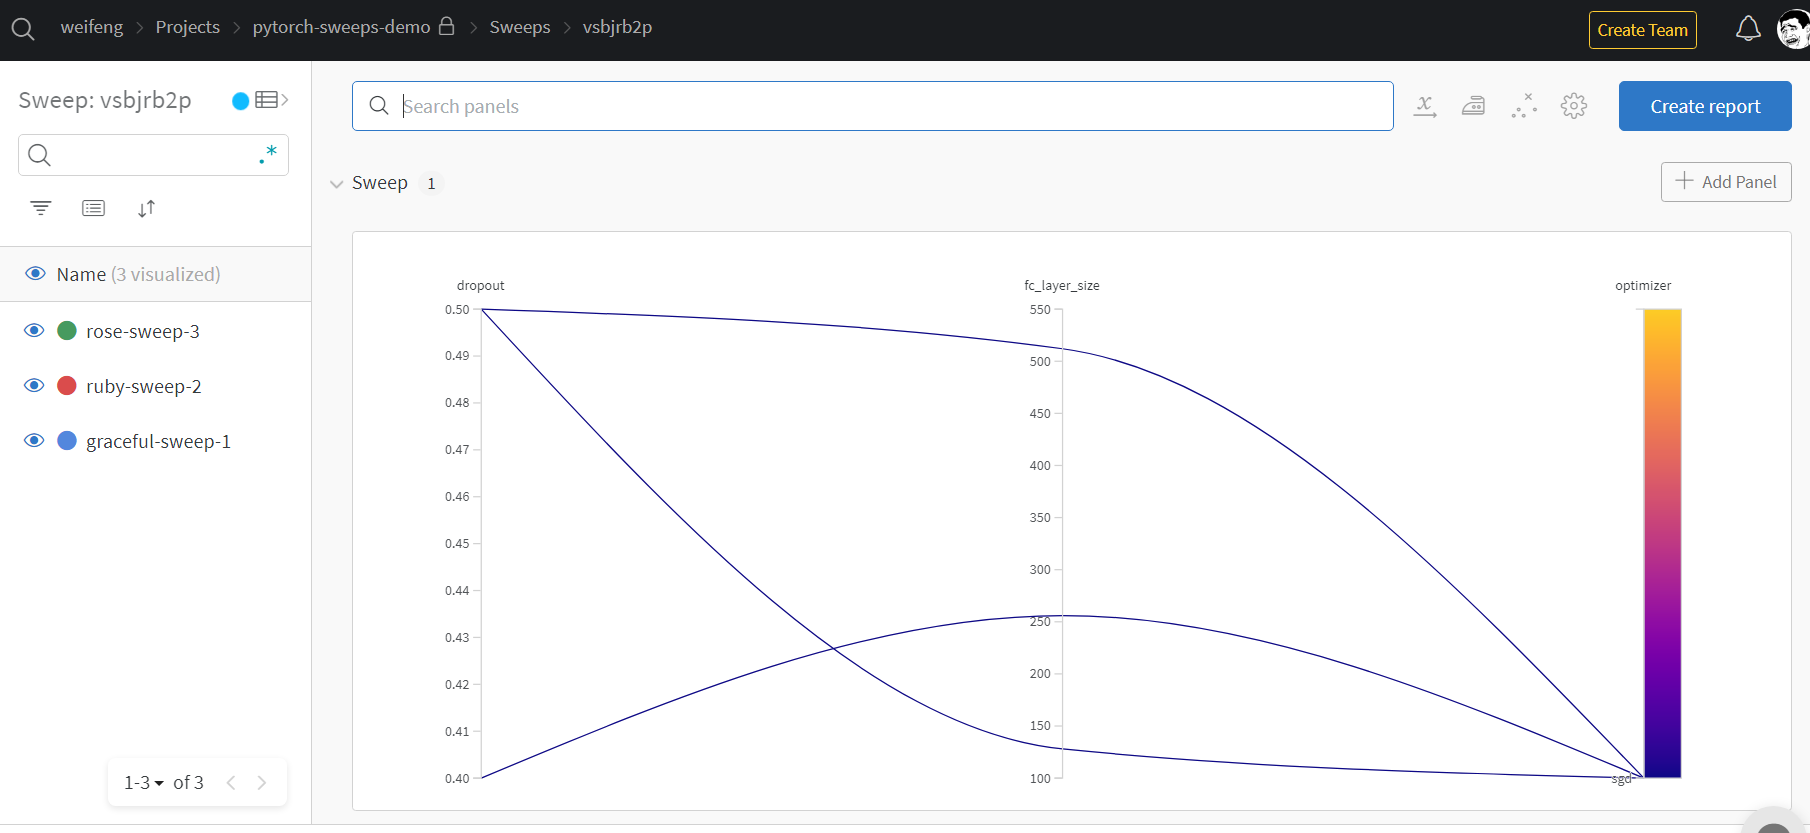

Link:https://wandb.ai/weifeng/pytorch-sweeps-demo/sweeps/vsbjrb2p?workspace=user-weifeng

## Keras

In [1]:
!pip install wandb -qqq
import wandb

     |████████████████████████████████| 1.8 MB 7.4 MB/s 
     |████████████████████████████████| 181 kB 26.9 MB/s 
     |████████████████████████████████| 144 kB 46.9 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 


In [2]:
# Log in to your W&B account
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
import random

# Launch 5 simulated experiments
for run in range(5):
  # 1️⃣ Start a new run to track this script
  wandb.init(
      # Set entity to specify your username or team name
      # ex: entity="carey",
      # Set the project where this run will be logged
      project="basic-intro", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.02,
      "architecture": "CNN",
      "dataset": "CIFAR-100",})
  
  # This simple block simulates a training loop logging metrics
  offset = random.random() / 5
  for ii in range(2, 10):
      acc = 1 - 2 ** -ii - random.random() / ii - offset
      loss = 2 ** -ii + random.random() / ii + offset
      # 2️⃣ Log metrics from your script to W&B
      wandb.log({"acc": acc, "loss": loss})
      
  # Mark the run as finished
  wandb.finish()

wandb: Currently logged in as: weifeng (use `wandb login --relogin` to force relogin)


acc,▁▃▅█▇██▇
loss,█▆▂▃▂▁▂▂
acc,0.83981
loss,0.16079


acc,▁▃▇▇▆▇██
loss,█▅▂▃▁▂▂▂
acc,0.88439
loss,0.17979


acc,▁▃▆█▇▇█▇
loss,█▄▄▃▂▁▁▂
acc,0.72529
loss,0.29487


acc,▄▁▅▆█▆██
loss,█▆▃▃▁▁▂▁
acc,0.82748
loss,0.133


acc,▁▅▆█▇▆██
loss,█▅▇▃▂▃▂▁
acc,0.73899
loss,0.19467


In [4]:
import random

import numpy as np
import tensorflow as tf
from wandb.keras import WandbCallback

# Simple Keras Model

# Launch 20 experiments, trying different dropout rates
for run in range(20):
  # Start a run, tracking hyperparameters
  wandb.init(
      project="keras-intro",
      # Set entity to specify your username or team name
      # ex: entity="wandb",
      config={
          "layer_1": 512,
          "activation_1": "relu",
          "dropout": random.uniform(0.01, 0.80),
          "layer_2": 10,
          "activation_2": "softmax",
          "optimizer": "sgd",
          "loss": "sparse_categorical_crossentropy",
          "metric": "accuracy",
          "epoch": 6,
          "batch_size": 256
      })
  config = wandb.config

  # Get the data
  mnist = tf.keras.datasets.mnist
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train, x_test = x_train / 255.0, x_test / 255.0
  x_train, y_train = x_train[::5], y_train[::5]  # Subset data for a faster demo
  x_test, y_test = x_test[::20], y_test[::20]
  labels = [str(digit) for digit in range(np.max(y_train) + 1)]

  # Build a model
  model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(config.layer_1, activation=config.activation_1),
      tf.keras.layers.Dropout(config.dropout),
      tf.keras.layers.Dense(config.layer_2, activation=config.activation_2)
      ])

  model.compile(optimizer=config.optimizer,
                loss=config.loss,
                metrics=[config.metric]
                )

  # WandbCallback auto-saves all metrics from model.fit(), plus predictions on validation_data
  logging_callback = WandbCallback(log_evaluation=True)

  history = model.fit(x=x_train, y=y_train,
                      epochs=config.epoch,
                      batch_size=config.batch_size,
                      validation_data=(x_test, y_test),
                      callbacks=[logging_callback]
                      )

  # Mark the run as finished
  wandb.finish()

11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/6
47/47 [==============================] - 3s 7ms/step - loss: 2.1092 - accuracy: 0.2866 - val_loss: 1.8492 - val_accuracy: 0.5820 - _timestamp: 1650655233.0000 - _runtime: 23.0000
Epoch 2/6
47/47 [==============================] - 0s 4ms/step - loss: 1.7099 - accuracy: 0.5592 - val_loss: 1.5044 - val_accuracy: 0.7300 - _timestamp: 1650655233.0000 - _runtime: 23.0000
Epoch 3/6
47/47 [==============================] - 0s 7ms/step - loss: 1.4194 - accuracy: 0.6767 - val_loss: 1.2476 - val_accuracy: 0.7720 - _timestamp: 1650655233.0000 - _runtime: 23.0000
Epoch 4/6
47/47 [==============================] - 0s 4ms/step - loss: 1.2091 - accuracy: 0.7246 - val_loss: 1.0632 - val_accuracy: 0.8040 - _timestamp: 1650655233.0000 - _runtime: 23.0000
Epoch 5/6
47/47 [==============================] - 0s 4ms/step - loss: 1.0543 - accuracy: 0.7554 - val_loss: 0.9296 - val_accuracy: 0.8220 - _timestamp: 1650655233.0000 - _runtime

accuracy,▁▅▇▇██
epoch,▁▂▄▅▇█
loss,█▆▄▃▂▁
val_accuracy,▁▅▆▇██
val_loss,█▆▄▃▂▁
accuracy,0.77867
best_epoch,5
best_val_loss,0.83445
epoch,5
loss,0.94439
val_accuracy,0.826


Epoch 1/6
47/47 [==============================] - 1s 7ms/step - loss: 2.2387 - accuracy: 0.2002 - val_loss: 1.8569 - val_accuracy: 0.5500 - _timestamp: 1650655244.0000 - _runtime: 6.0000
Epoch 2/6
47/47 [==============================] - 0s 4ms/step - loss: 1.8377 - accuracy: 0.3964 - val_loss: 1.5437 - val_accuracy: 0.6780 - _timestamp: 1650655244.0000 - _runtime: 6.0000
Epoch 3/6
47/47 [==============================] - 0s 4ms/step - loss: 1.5782 - accuracy: 0.5190 - val_loss: 1.3119 - val_accuracy: 0.7400 - _timestamp: 1650655245.0000 - _runtime: 7.0000
Epoch 4/6
47/47 [==============================] - 0s 4ms/step - loss: 1.3868 - accuracy: 0.5871 - val_loss: 1.1375 - val_accuracy: 0.7780 - _timestamp: 1650655245.0000 - _runtime: 7.0000
Epoch 5/6
47/47 [==============================] - 0s 4ms/step - loss: 1.2390 - accuracy: 0.6404 - val_loss: 1.0072 - val_accuracy: 0.7900 - _timestamp: 1650655245.0000 - _runtime: 7.0000
Epoch 6/6
47/47 [==============================] - 0s 4ms/st

accuracy,▁▄▆▇██
epoch,▁▂▄▅▇█
loss,█▅▄▃▂▁
val_accuracy,▁▄▆▇▇█
val_loss,█▆▄▃▂▁
accuracy,0.671
best_epoch,5
best_val_loss,0.9061
epoch,5
loss,1.13396
val_accuracy,0.814


Epoch 1/6
47/47 [==============================] - 1s 7ms/step - loss: 2.0908 - accuracy: 0.2925 - val_loss: 1.8229 - val_accuracy: 0.6040 - _timestamp: 1650655256.0000 - _runtime: 6.0000
Epoch 2/6
47/47 [==============================] - 0s 4ms/step - loss: 1.6703 - accuracy: 0.5899 - val_loss: 1.4664 - val_accuracy: 0.7280 - _timestamp: 1650655256.0000 - _runtime: 6.0000
Epoch 3/6
47/47 [==============================] - 0s 4ms/step - loss: 1.3714 - accuracy: 0.7011 - val_loss: 1.2121 - val_accuracy: 0.7720 - _timestamp: 1650655257.0000 - _runtime: 7.0000
Epoch 4/6
47/47 [==============================] - 0s 4ms/step - loss: 1.1605 - accuracy: 0.7473 - val_loss: 1.0331 - val_accuracy: 0.7880 - _timestamp: 1650655257.0000 - _runtime: 7.0000
Epoch 5/6
47/47 [==============================] - 0s 4ms/step - loss: 1.0114 - accuracy: 0.7743 - val_loss: 0.9096 - val_accuracy: 0.8020 - _timestamp: 1650655257.0000 - _runtime: 7.0000
Epoch 6/6
47/47 [==============================] - 0s 4ms/st

accuracy,▁▅▇▇██
epoch,▁▂▄▅▇█
loss,█▆▄▃▂▁
val_accuracy,▁▅▆▇▇█
val_loss,█▆▄▂▂▁
accuracy,0.79233
best_epoch,5
best_val_loss,0.81822
epoch,5
loss,0.90655
val_accuracy,0.82


Epoch 1/6
47/47 [==============================] - 1s 11ms/step - loss: 2.2598 - accuracy: 0.1920 - val_loss: 1.8749 - val_accuracy: 0.5780 - _timestamp: 1650655274.0000 - _runtime: 11.0000
Epoch 2/6
47/47 [==============================] - 0s 7ms/step - loss: 1.8711 - accuracy: 0.3869 - val_loss: 1.5619 - val_accuracy: 0.7080 - _timestamp: 1650655274.0000 - _runtime: 11.0000
Epoch 3/6
47/47 [==============================] - 0s 6ms/step - loss: 1.6127 - accuracy: 0.5051 - val_loss: 1.3315 - val_accuracy: 0.7680 - _timestamp: 1650655275.0000 - _runtime: 12.0000
Epoch 4/6
47/47 [==============================] - 0s 9ms/step - loss: 1.4361 - accuracy: 0.5753 - val_loss: 1.1571 - val_accuracy: 0.7840 - _timestamp: 1650655275.0000 - _runtime: 12.0000
Epoch 5/6
47/47 [==============================] - 0s 6ms/step - loss: 1.2730 - accuracy: 0.6318 - val_loss: 1.0251 - val_accuracy: 0.7940 - _timestamp: 1650655275.0000 - _runtime: 12.0000
Epoch 6/6
47/47 [==============================] - 0s 

accuracy,▁▄▆▇██
epoch,▁▂▄▅▇█
loss,█▆▄▃▂▁
val_accuracy,▁▅▇▇▇█
val_loss,█▆▄▃▂▁
accuracy,0.65992
best_epoch,5
best_val_loss,0.92297
epoch,5
loss,1.16421
val_accuracy,0.816


Epoch 1/6
47/47 [==============================] - 1s 7ms/step - loss: 2.2005 - accuracy: 0.2207 - val_loss: 1.9165 - val_accuracy: 0.5220 - _timestamp: 1650655288.0000 - _runtime: 6.0000
Epoch 2/6
47/47 [==============================] - 0s 4ms/step - loss: 1.7961 - accuracy: 0.4839 - val_loss: 1.5731 - val_accuracy: 0.7060 - _timestamp: 1650655288.0000 - _runtime: 6.0000
Epoch 3/6
47/47 [==============================] - 0s 4ms/step - loss: 1.5071 - accuracy: 0.6136 - val_loss: 1.3133 - val_accuracy: 0.7480 - _timestamp: 1650655288.0000 - _runtime: 6.0000
Epoch 4/6
47/47 [==============================] - 0s 4ms/step - loss: 1.2868 - accuracy: 0.6830 - val_loss: 1.1216 - val_accuracy: 0.7840 - _timestamp: 1650655288.0000 - _runtime: 6.0000
Epoch 5/6
47/47 [==============================] - 0s 4ms/step - loss: 1.1309 - accuracy: 0.7177 - val_loss: 0.9816 - val_accuracy: 0.8080 - _timestamp: 1650655288.0000 - _runtime: 6.0000
Epoch 6/6
47/47 [==============================] - 0s 4ms/st

accuracy,▁▅▆▇██
epoch,▁▂▄▅▇█
loss,█▆▄▃▂▁
val_accuracy,▁▅▆▇██
val_loss,█▆▄▃▂▁
accuracy,0.7435
best_epoch,5
best_val_loss,0.87884
epoch,5
loss,1.01483
val_accuracy,0.812


Epoch 1/6
47/47 [==============================] - 1s 7ms/step - loss: 2.2545 - accuracy: 0.1873 - val_loss: 1.8939 - val_accuracy: 0.5480 - _timestamp: 1650655302.0000 - _runtime: 8.0000
Epoch 2/6
47/47 [==============================] - 0s 4ms/step - loss: 1.8615 - accuracy: 0.3811 - val_loss: 1.5675 - val_accuracy: 0.7100 - _timestamp: 1650655302.0000 - _runtime: 8.0000
Epoch 3/6
47/47 [==============================] - 0s 4ms/step - loss: 1.5925 - accuracy: 0.5222 - val_loss: 1.3253 - val_accuracy: 0.7680 - _timestamp: 1650655302.0000 - _runtime: 8.0000
Epoch 4/6
47/47 [==============================] - 0s 4ms/step - loss: 1.3871 - accuracy: 0.6022 - val_loss: 1.1444 - val_accuracy: 0.7940 - _timestamp: 1650655302.0000 - _runtime: 8.0000
Epoch 5/6
47/47 [==============================] - 0s 4ms/step - loss: 1.2426 - accuracy: 0.6474 - val_loss: 1.0100 - val_accuracy: 0.8040 - _timestamp: 1650655303.0000 - _runtime: 9.0000
Epoch 6/6
47/47 [==============================] - 0s 4ms/st

accuracy,▁▄▆▇██
epoch,▁▂▄▅▇█
loss,█▆▄▃▂▁
val_accuracy,▁▅▇▇▇█
val_loss,█▆▄▃▂▁
accuracy,0.68242
best_epoch,5
best_val_loss,0.90527
epoch,5
loss,1.12556
val_accuracy,0.824


Epoch 1/6
47/47 [==============================] - 1s 7ms/step - loss: 2.1512 - accuracy: 0.2479 - val_loss: 1.8816 - val_accuracy: 0.5780 - _timestamp: 1650655314.0000 - _runtime: 6.0000
Epoch 2/6
47/47 [==============================] - 0s 4ms/step - loss: 1.7551 - accuracy: 0.5118 - val_loss: 1.5433 - val_accuracy: 0.7240 - _timestamp: 1650655314.0000 - _runtime: 6.0000
Epoch 3/6
47/47 [==============================] - 0s 4ms/step - loss: 1.4661 - accuracy: 0.6436 - val_loss: 1.2917 - val_accuracy: 0.7700 - _timestamp: 1650655314.0000 - _runtime: 6.0000
Epoch 4/6
47/47 [==============================] - 0s 4ms/step - loss: 1.2542 - accuracy: 0.7032 - val_loss: 1.1060 - val_accuracy: 0.7880 - _timestamp: 1650655314.0000 - _runtime: 6.0000
Epoch 5/6
47/47 [==============================] - 0s 4ms/step - loss: 1.1076 - accuracy: 0.7299 - val_loss: 0.9714 - val_accuracy: 0.7980 - _timestamp: 1650655315.0000 - _runtime: 7.0000
Epoch 6/6
47/47 [==============================] - 0s 4ms/st

accuracy,▁▅▆▇██
epoch,▁▂▄▅▇█
loss,█▆▄▃▂▁
val_accuracy,▁▆▇███
val_loss,█▆▄▃▂▁
accuracy,0.75583
best_epoch,5
best_val_loss,0.87208
epoch,5
loss,0.98894
val_accuracy,0.802


Epoch 1/6
47/47 [==============================] - 1s 7ms/step - loss: 2.1863 - accuracy: 0.2103 - val_loss: 1.8641 - val_accuracy: 0.5900 - _timestamp: 1650655326.0000 - _runtime: 6.0000
Epoch 2/6
47/47 [==============================] - 0s 4ms/step - loss: 1.7870 - accuracy: 0.4395 - val_loss: 1.5358 - val_accuracy: 0.6960 - _timestamp: 1650655326.0000 - _runtime: 6.0000
Epoch 3/6
47/47 [==============================] - 0s 4ms/step - loss: 1.5133 - accuracy: 0.5736 - val_loss: 1.2917 - val_accuracy: 0.7580 - _timestamp: 1650655327.0000 - _runtime: 7.0000
Epoch 4/6
47/47 [==============================] - 0s 4ms/step - loss: 1.3142 - accuracy: 0.6423 - val_loss: 1.1124 - val_accuracy: 0.7900 - _timestamp: 1650655327.0000 - _runtime: 7.0000
Epoch 5/6
47/47 [==============================] - 0s 4ms/step - loss: 1.1630 - accuracy: 0.6862 - val_loss: 0.9810 - val_accuracy: 0.8000 - _timestamp: 1650655327.0000 - _runtime: 7.0000
Epoch 6/6
47/47 [==============================] - 0s 4ms/st

accuracy,▁▄▆▇██
epoch,▁▂▄▅▇█
loss,█▆▄▃▂▁
val_accuracy,▁▄▆▇██
val_loss,█▆▄▃▂▁
accuracy,0.7155
best_epoch,5
best_val_loss,0.88129
epoch,5
loss,1.0538
val_accuracy,0.814


Epoch 1/6
47/47 [==============================] - 1s 7ms/step - loss: 2.1530 - accuracy: 0.2836 - val_loss: 1.9215 - val_accuracy: 0.5400 - _timestamp: 1650655338.0000 - _runtime: 6.0000
Epoch 2/6
47/47 [==============================] - 0s 4ms/step - loss: 1.7428 - accuracy: 0.6241 - val_loss: 1.5634 - val_accuracy: 0.7120 - _timestamp: 1650655338.0000 - _runtime: 6.0000
Epoch 3/6
47/47 [==============================] - 0s 4ms/step - loss: 1.4304 - accuracy: 0.7268 - val_loss: 1.2917 - val_accuracy: 0.7560 - _timestamp: 1650655338.0000 - _runtime: 6.0000
Epoch 4/6
47/47 [==============================] - 0s 4ms/step - loss: 1.1960 - accuracy: 0.7691 - val_loss: 1.0932 - val_accuracy: 0.7840 - _timestamp: 1650655338.0000 - _runtime: 6.0000
Epoch 5/6
47/47 [==============================] - 0s 4ms/step - loss: 1.0278 - accuracy: 0.7994 - val_loss: 0.9516 - val_accuracy: 0.7960 - _timestamp: 1650655339.0000 - _runtime: 7.0000
Epoch 6/6
47/47 [==============================] - 0s 4ms/st

accuracy,▁▅▇▇██
epoch,▁▂▄▅▇█
loss,█▆▄▃▂▁
val_accuracy,▁▆▇▇██
val_loss,█▆▄▃▂▁
accuracy,0.81367
best_epoch,5
best_val_loss,0.84877
epoch,5
loss,0.9079
val_accuracy,0.804


Epoch 1/6
47/47 [==============================] - 1s 7ms/step - loss: 2.1019 - accuracy: 0.2848 - val_loss: 1.8212 - val_accuracy: 0.5980 - _timestamp: 1650655350.0000 - _runtime: 6.0000
Epoch 2/6
47/47 [==============================] - 0s 4ms/step - loss: 1.6827 - accuracy: 0.5790 - val_loss: 1.4653 - val_accuracy: 0.7140 - _timestamp: 1650655350.0000 - _runtime: 6.0000
Epoch 3/6
47/47 [==============================] - 0s 4ms/step - loss: 1.3868 - accuracy: 0.6886 - val_loss: 1.2117 - val_accuracy: 0.7520 - _timestamp: 1650655351.0000 - _runtime: 7.0000
Epoch 4/6
47/47 [==============================] - 0s 4ms/step - loss: 1.1747 - accuracy: 0.7353 - val_loss: 1.0336 - val_accuracy: 0.7780 - _timestamp: 1650655351.0000 - _runtime: 7.0000
Epoch 5/6
47/47 [==============================] - 0s 4ms/step - loss: 1.0214 - accuracy: 0.7653 - val_loss: 0.9078 - val_accuracy: 0.8040 - _timestamp: 1650655351.0000 - _runtime: 7.0000
Epoch 6/6
47/47 [==============================] - 0s 4ms/st

accuracy,▁▅▇▇██
epoch,▁▂▄▅▇█
loss,█▆▄▃▂▁
val_accuracy,▁▅▆▇██
val_loss,█▆▄▃▂▁
accuracy,0.78517
best_epoch,5
best_val_loss,0.81727
epoch,5
loss,0.91683
val_accuracy,0.818


Epoch 1/6
47/47 [==============================] - 1s 7ms/step - loss: 2.1483 - accuracy: 0.2900 - val_loss: 1.8872 - val_accuracy: 0.5780 - _timestamp: 1650655364.0000 - _runtime: 8.0000
Epoch 2/6
47/47 [==============================] - 0s 4ms/step - loss: 1.7302 - accuracy: 0.6071 - val_loss: 1.5336 - val_accuracy: 0.7120 - _timestamp: 1650655364.0000 - _runtime: 8.0000
Epoch 3/6
47/47 [==============================] - 0s 4ms/step - loss: 1.4206 - accuracy: 0.7188 - val_loss: 1.2654 - val_accuracy: 0.7560 - _timestamp: 1650655364.0000 - _runtime: 8.0000
Epoch 4/6
47/47 [==============================] - 0s 4ms/step - loss: 1.1914 - accuracy: 0.7675 - val_loss: 1.0727 - val_accuracy: 0.7960 - _timestamp: 1650655364.0000 - _runtime: 8.0000
Epoch 5/6
47/47 [==============================] - 0s 4ms/step - loss: 1.0281 - accuracy: 0.7918 - val_loss: 0.9353 - val_accuracy: 0.8060 - _timestamp: 1650655364.0000 - _runtime: 8.0000
Epoch 6/6
47/47 [==============================] - 0s 4ms/st

accuracy,▁▅▇▇██
epoch,▁▂▄▅▇█
loss,█▆▄▃▂▁
val_accuracy,▁▅▆▇██
val_loss,█▆▄▃▂▁
accuracy,0.81092
best_epoch,5
best_val_loss,0.83537
epoch,5
loss,0.90763
val_accuracy,0.818


Epoch 1/6
47/47 [==============================] - 1s 8ms/step - loss: 2.1311 - accuracy: 0.2598 - val_loss: 1.8609 - val_accuracy: 0.5820 - _timestamp: 1650655376.0000 - _runtime: 6.0000
Epoch 2/6
47/47 [==============================] - 0s 4ms/step - loss: 1.7130 - accuracy: 0.5594 - val_loss: 1.5113 - val_accuracy: 0.6960 - _timestamp: 1650655376.0000 - _runtime: 6.0000
Epoch 3/6
47/47 [==============================] - 0s 4ms/step - loss: 1.4210 - accuracy: 0.6654 - val_loss: 1.2574 - val_accuracy: 0.7440 - _timestamp: 1650655376.0000 - _runtime: 6.0000
Epoch 4/6
47/47 [==============================] - 0s 4ms/step - loss: 1.2130 - accuracy: 0.7104 - val_loss: 1.0717 - val_accuracy: 0.7820 - _timestamp: 1650655377.0000 - _runtime: 7.0000
Epoch 5/6
47/47 [==============================] - 0s 5ms/step - loss: 1.0602 - accuracy: 0.7497 - val_loss: 0.9388 - val_accuracy: 0.8040 - _timestamp: 1650655377.0000 - _runtime: 7.0000
Epoch 6/6
47/47 [==============================] - 0s 4ms/st

accuracy,▁▅▇▇██
epoch,▁▂▄▅▇█
loss,█▆▄▃▂▁
val_accuracy,▁▄▆▇██
val_loss,█▆▄▃▂▁
accuracy,0.775
best_epoch,5
best_val_loss,0.84267
epoch,5
loss,0.94562
val_accuracy,0.82


Epoch 1/6
47/47 [==============================] - 1s 7ms/step - loss: 2.1021 - accuracy: 0.2686 - val_loss: 1.8030 - val_accuracy: 0.6320 - _timestamp: 1650655388.0000 - _runtime: 6.0000
Epoch 2/6
47/47 [==============================] - 0s 4ms/step - loss: 1.7067 - accuracy: 0.5217 - val_loss: 1.4666 - val_accuracy: 0.7540 - _timestamp: 1650655389.0000 - _runtime: 7.0000
Epoch 3/6
47/47 [==============================] - 0s 6ms/step - loss: 1.4245 - accuracy: 0.6387 - val_loss: 1.2231 - val_accuracy: 0.7860 - _timestamp: 1650655389.0000 - _runtime: 7.0000
Epoch 4/6
47/47 [==============================] - 0s 5ms/step - loss: 1.2146 - accuracy: 0.7072 - val_loss: 1.0471 - val_accuracy: 0.8140 - _timestamp: 1650655389.0000 - _runtime: 7.0000
Epoch 5/6
47/47 [==============================] - 0s 4ms/step - loss: 1.0735 - accuracy: 0.7338 - val_loss: 0.9212 - val_accuracy: 0.8220 - _timestamp: 1650655389.0000 - _runtime: 7.0000
Epoch 6/6
47/47 [==============================] - 0s 4ms/st

accuracy,▁▅▆▇██
epoch,▁▂▄▅▇█
loss,█▆▄▃▂▁
val_accuracy,▁▅▇▇██
val_loss,█▆▄▃▂▁
accuracy,0.75833
best_epoch,5
best_val_loss,0.82814
epoch,5
loss,0.9705
val_accuracy,0.828


Epoch 1/6
47/47 [==============================] - 1s 7ms/step - loss: 2.1266 - accuracy: 0.2582 - val_loss: 1.8309 - val_accuracy: 0.6180 - _timestamp: 1650655401.0000 - _runtime: 6.0000
Epoch 2/6
47/47 [==============================] - 0s 4ms/step - loss: 1.6997 - accuracy: 0.5447 - val_loss: 1.4711 - val_accuracy: 0.7440 - _timestamp: 1650655401.0000 - _runtime: 6.0000
Epoch 3/6
47/47 [==============================] - 0s 4ms/step - loss: 1.4065 - accuracy: 0.6587 - val_loss: 1.2156 - val_accuracy: 0.7980 - _timestamp: 1650655401.0000 - _runtime: 6.0000
Epoch 4/6
47/47 [==============================] - 0s 4ms/step - loss: 1.1938 - accuracy: 0.7189 - val_loss: 1.0382 - val_accuracy: 0.8100 - _timestamp: 1650655401.0000 - _runtime: 6.0000
Epoch 5/6
47/47 [==============================] - 0s 4ms/step - loss: 1.0477 - accuracy: 0.7495 - val_loss: 0.9136 - val_accuracy: 0.8120 - _timestamp: 1650655401.0000 - _runtime: 6.0000
Epoch 6/6
47/47 [==============================] - 0s 4ms/st

accuracy,▁▅▆▇██
epoch,▁▂▄▅▇█
loss,█▅▄▂▂▁
val_accuracy,▁▅▇███
val_loss,█▆▄▃▂▁
accuracy,0.77108
best_epoch,5
best_val_loss,0.82127
epoch,5
loss,0.94173
val_accuracy,0.822


Epoch 1/6
47/47 [==============================] - 1s 7ms/step - loss: 2.2067 - accuracy: 0.2028 - val_loss: 1.8463 - val_accuracy: 0.5620 - _timestamp: 1650655413.0000 - _runtime: 6.0000
Epoch 2/6
47/47 [==============================] - 0s 4ms/step - loss: 1.7933 - accuracy: 0.4313 - val_loss: 1.5086 - val_accuracy: 0.6760 - _timestamp: 1650655413.0000 - _runtime: 6.0000
Epoch 3/6
47/47 [==============================] - 0s 4ms/step - loss: 1.5068 - accuracy: 0.5652 - val_loss: 1.2637 - val_accuracy: 0.7440 - _timestamp: 1650655413.0000 - _runtime: 6.0000
Epoch 4/6
47/47 [==============================] - 0s 4ms/step - loss: 1.3136 - accuracy: 0.6303 - val_loss: 1.0875 - val_accuracy: 0.7640 - _timestamp: 1650655414.0000 - _runtime: 7.0000
Epoch 5/6
47/47 [==============================] - 0s 4ms/step - loss: 1.1609 - accuracy: 0.6739 - val_loss: 0.9600 - val_accuracy: 0.7840 - _timestamp: 1650655414.0000 - _runtime: 7.0000
Epoch 6/6
47/47 [==============================] - 0s 4ms/st

accuracy,▁▄▆▇██
epoch,▁▂▄▅▇█
loss,█▅▄▃▂▁
val_accuracy,▁▄▆▇██
val_loss,█▆▄▃▂▁
accuracy,0.70925
best_epoch,5
best_val_loss,0.86529
epoch,5
loss,1.04958
val_accuracy,0.8


Epoch 1/6
47/47 [==============================] - 1s 7ms/step - loss: 2.1451 - accuracy: 0.2437 - val_loss: 1.8601 - val_accuracy: 0.5400 - _timestamp: 1650655426.0000 - _runtime: 8.0000
Epoch 2/6
47/47 [==============================] - 0s 4ms/step - loss: 1.7360 - accuracy: 0.5175 - val_loss: 1.5153 - val_accuracy: 0.6980 - _timestamp: 1650655426.0000 - _runtime: 8.0000
Epoch 3/6
47/47 [==============================] - 0s 4ms/step - loss: 1.4413 - accuracy: 0.6428 - val_loss: 1.2651 - val_accuracy: 0.7660 - _timestamp: 1650655426.0000 - _runtime: 8.0000
Epoch 4/6
47/47 [==============================] - 0s 4ms/step - loss: 1.2386 - accuracy: 0.6945 - val_loss: 1.0831 - val_accuracy: 0.8000 - _timestamp: 1650655426.0000 - _runtime: 8.0000
Epoch 5/6
47/47 [==============================] - 0s 4ms/step - loss: 1.0833 - accuracy: 0.7340 - val_loss: 0.9512 - val_accuracy: 0.8060 - _timestamp: 1650655426.0000 - _runtime: 8.0000
Epoch 6/6
47/47 [==============================] - 0s 4ms/st

accuracy,▁▅▆▇██
epoch,▁▂▄▅▇█
loss,█▆▄▃▂▁
val_accuracy,▁▅▇███
val_loss,█▆▄▃▂▁
accuracy,0.7555
best_epoch,5
best_val_loss,0.85532
epoch,5
loss,0.97099
val_accuracy,0.816


Epoch 1/6
47/47 [==============================] - 1s 7ms/step - loss: 2.0763 - accuracy: 0.3216 - val_loss: 1.8117 - val_accuracy: 0.6180 - _timestamp: 1650655439.0000 - _runtime: 6.0000
Epoch 2/6
47/47 [==============================] - 0s 4ms/step - loss: 1.6668 - accuracy: 0.5975 - val_loss: 1.4589 - val_accuracy: 0.7300 - _timestamp: 1650655439.0000 - _runtime: 6.0000
Epoch 3/6
47/47 [==============================] - 0s 4ms/step - loss: 1.3716 - accuracy: 0.7018 - val_loss: 1.2047 - val_accuracy: 0.7620 - _timestamp: 1650655439.0000 - _runtime: 6.0000
Epoch 4/6
47/47 [==============================] - 0s 4ms/step - loss: 1.1612 - accuracy: 0.7513 - val_loss: 1.0255 - val_accuracy: 0.7940 - _timestamp: 1650655439.0000 - _runtime: 6.0000
Epoch 5/6
47/47 [==============================] - 0s 4ms/step - loss: 1.0070 - accuracy: 0.7770 - val_loss: 0.8982 - val_accuracy: 0.8140 - _timestamp: 1650655440.0000 - _runtime: 7.0000
Epoch 6/6
47/47 [==============================] - 0s 4ms/st

accuracy,▁▅▇▇██
epoch,▁▂▄▅▇█
loss,█▆▄▃▂▁
val_accuracy,▁▅▆▇██
val_loss,█▆▄▃▂▁
accuracy,0.80058
best_epoch,5
best_val_loss,0.80618
epoch,5
loss,0.8959
val_accuracy,0.818


Epoch 1/6
47/47 [==============================] - 1s 7ms/step - loss: 2.2941 - accuracy: 0.1757 - val_loss: 1.9035 - val_accuracy: 0.5760 - _timestamp: 1650655451.0000 - _runtime: 6.0000
Epoch 2/6
47/47 [==============================] - 0s 4ms/step - loss: 1.9147 - accuracy: 0.3506 - val_loss: 1.5870 - val_accuracy: 0.7020 - _timestamp: 1650655451.0000 - _runtime: 6.0000
Epoch 3/6
47/47 [==============================] - 0s 4ms/step - loss: 1.6429 - accuracy: 0.4852 - val_loss: 1.3538 - val_accuracy: 0.7540 - _timestamp: 1650655452.0000 - _runtime: 7.0000
Epoch 4/6
47/47 [==============================] - 0s 4ms/step - loss: 1.4437 - accuracy: 0.5603 - val_loss: 1.1750 - val_accuracy: 0.7900 - _timestamp: 1650655452.0000 - _runtime: 7.0000
Epoch 5/6
47/47 [==============================] - 0s 5ms/step - loss: 1.3034 - accuracy: 0.6155 - val_loss: 1.0402 - val_accuracy: 0.8000 - _timestamp: 1650655452.0000 - _runtime: 7.0000
Epoch 6/6
47/47 [==============================] - 0s 4ms/st

accuracy,▁▄▆▇▇█
epoch,▁▂▄▅▇█
loss,█▆▄▃▂▁
val_accuracy,▁▅▆▇██
val_loss,█▆▄▃▂▁
accuracy,0.65625
best_epoch,5
best_val_loss,0.93536
epoch,5
loss,1.17509
val_accuracy,0.816


Epoch 1/6
47/47 [==============================] - 1s 7ms/step - loss: 2.0715 - accuracy: 0.3311 - val_loss: 1.8238 - val_accuracy: 0.5840 - _timestamp: 1650655463.0000 - _runtime: 6.0000
Epoch 2/6
47/47 [==============================] - 0s 4ms/step - loss: 1.6477 - accuracy: 0.6295 - val_loss: 1.4629 - val_accuracy: 0.7100 - _timestamp: 1650655464.0000 - _runtime: 7.0000
Epoch 3/6
47/47 [==============================] - 0s 4ms/step - loss: 1.3424 - accuracy: 0.7234 - val_loss: 1.2034 - val_accuracy: 0.7860 - _timestamp: 1650655464.0000 - _runtime: 7.0000
Epoch 4/6
47/47 [==============================] - 0s 4ms/step - loss: 1.1284 - accuracy: 0.7685 - val_loss: 1.0218 - val_accuracy: 0.8120 - _timestamp: 1650655464.0000 - _runtime: 7.0000
Epoch 5/6
47/47 [==============================] - 0s 5ms/step - loss: 0.9782 - accuracy: 0.7950 - val_loss: 0.8959 - val_accuracy: 0.8240 - _timestamp: 1650655464.0000 - _runtime: 7.0000
Epoch 6/6
47/47 [==============================] - 0s 4ms/st

accuracy,▁▅▇▇██
epoch,▁▂▄▅▇█
loss,█▆▄▃▂▁
val_accuracy,▁▄▇▇██
val_loss,█▆▄▂▂▁
accuracy,0.81742
best_epoch,5
best_val_loss,0.80458
epoch,5
loss,0.86564
val_accuracy,0.836


Epoch 1/6
47/47 [==============================] - 1s 7ms/step - loss: 2.1127 - accuracy: 0.2713 - val_loss: 1.8559 - val_accuracy: 0.5660 - _timestamp: 1650655477.0000 - _runtime: 7.0000
Epoch 2/6
47/47 [==============================] - 0s 4ms/step - loss: 1.7017 - accuracy: 0.5533 - val_loss: 1.4961 - val_accuracy: 0.7160 - _timestamp: 1650655477.0000 - _runtime: 7.0000
Epoch 3/6
47/47 [==============================] - 0s 4ms/step - loss: 1.4013 - accuracy: 0.6777 - val_loss: 1.2366 - val_accuracy: 0.7480 - _timestamp: 1650655477.0000 - _runtime: 7.0000
Epoch 4/6
47/47 [==============================] - 0s 4ms/step - loss: 1.1907 - accuracy: 0.7280 - val_loss: 1.0540 - val_accuracy: 0.7760 - _timestamp: 1650655477.0000 - _runtime: 7.0000
Epoch 5/6
47/47 [==============================] - 0s 4ms/step - loss: 1.0328 - accuracy: 0.7613 - val_loss: 0.9249 - val_accuracy: 0.8000 - _timestamp: 1650655477.0000 - _runtime: 7.0000
Epoch 6/6
47/47 [==============================] - 0s 4ms/st

accuracy,▁▅▇▇██
epoch,▁▂▄▅▇█
loss,█▆▄▃▂▁
val_accuracy,▁▅▆▇██
val_loss,█▆▄▃▂▁
accuracy,0.7805
best_epoch,5
best_val_loss,0.83099
epoch,5
loss,0.92672
val_accuracy,0.81


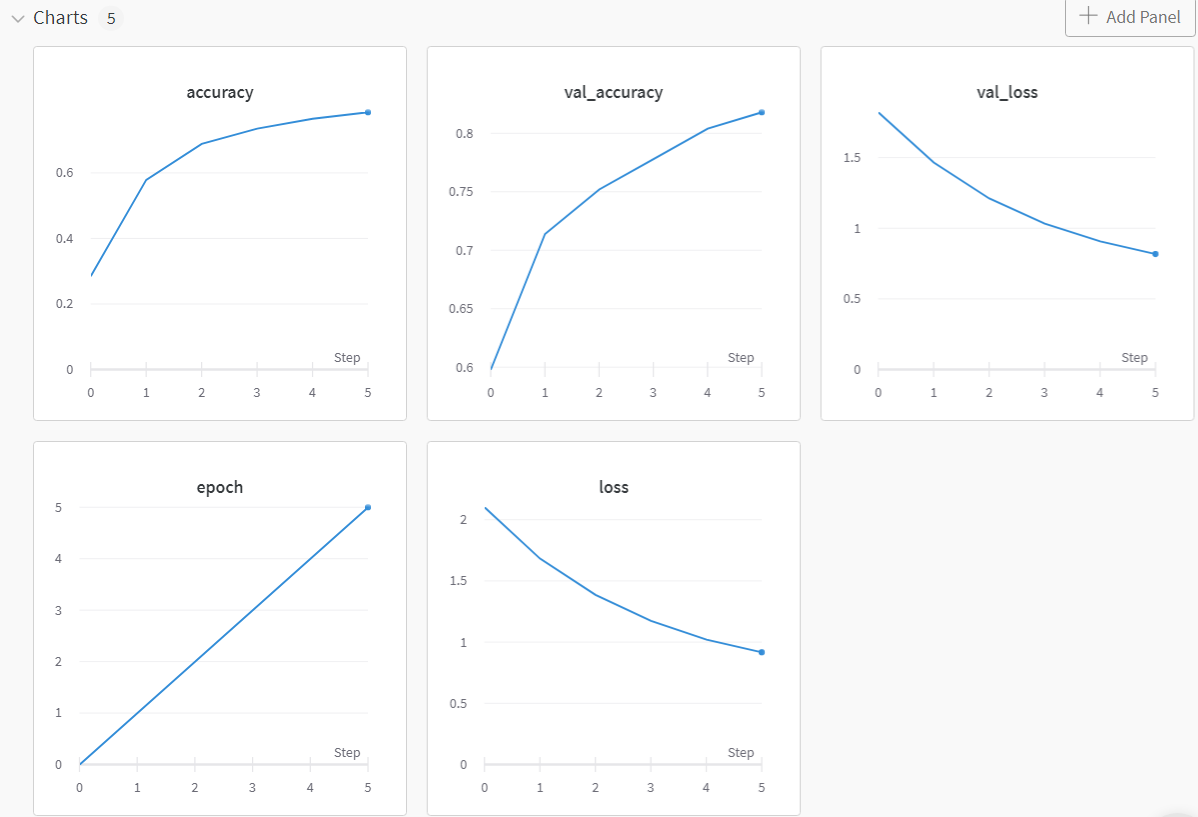

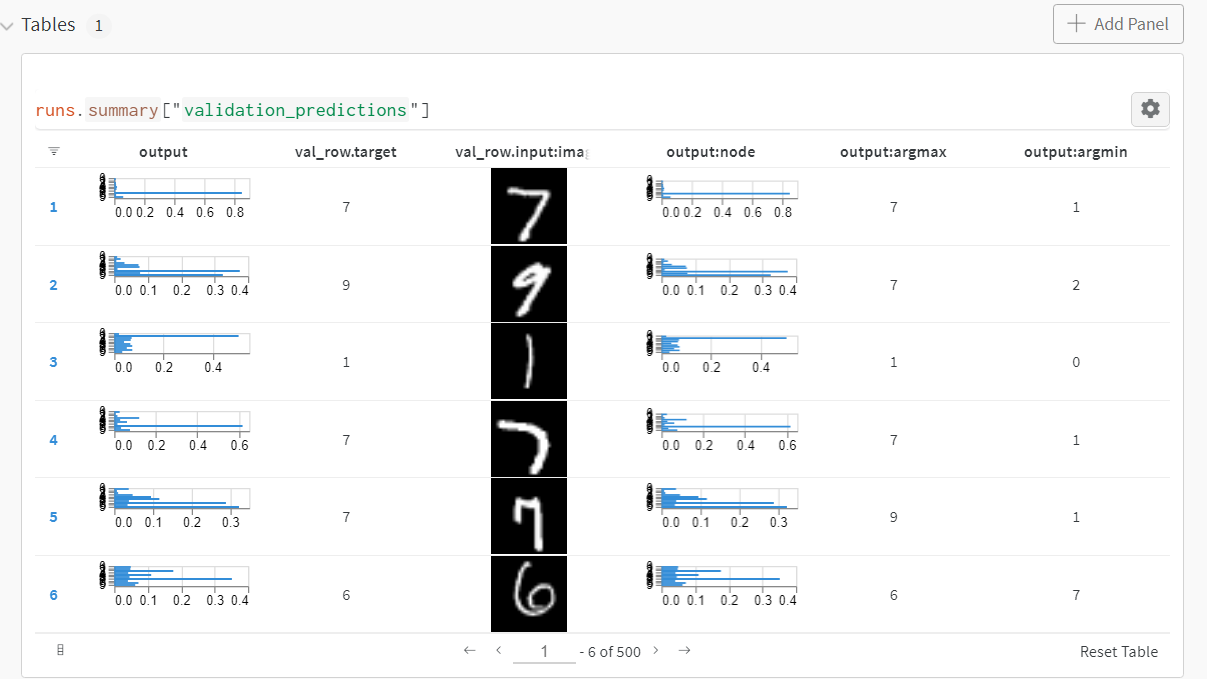

## Pytorch

In [1]:
import os
import random

import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# remove slow mirror from list of MNIST mirrors
torchvision.datasets.MNIST.mirrors = [mirror for mirror in torchvision.datasets.MNIST.mirrors
                                      if not mirror.startswith("http://yann.lecun.com")]

In [2]:
%%capture
!pip install wandb --upgrade

In [3]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
config = dict(
    epochs=5,
    classes=10,
    kernels=[16, 32],
    batch_size=128,
    learning_rate=0.005,
    dataset="MNIST",
    architecture="CNN")

In [5]:
def model_pipeline(hyperparameters):

    # tell wandb to get started
    with wandb.init(project="pytorch-demo", config=hyperparameters):
      # access all HPs through wandb.config, so logging matches execution!
      config = wandb.config

      # make the model, data, and optimization problem
      model, train_loader, test_loader, criterion, optimizer = make(config)
      print(model)

      # and use them to train the model
      train(model, train_loader, criterion, optimizer, config)

      # and test its final performance
      test(model, test_loader)

    return model

In [6]:
def make(config):
    # Make the data
    train, test = get_data(train=True), get_data(train=False)
    train_loader = make_loader(train, batch_size=config.batch_size)
    test_loader = make_loader(test, batch_size=config.batch_size)

    # Make the model
    model = ConvNet(config.kernels, config.classes).to(device)

    # Make the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=config.learning_rate)
    
    return model, train_loader, test_loader, criterion, optimizer

In [7]:
def get_data(slice=5, train=True):
    full_dataset = torchvision.datasets.MNIST(root=".",
                                              train=train, 
                                              transform=transforms.ToTensor(),
                                              download=True)
    #  equiv to slicing with [::slice] 
    sub_dataset = torch.utils.data.Subset(
      full_dataset, indices=range(0, len(full_dataset), slice))
    
    return sub_dataset


def make_loader(dataset, batch_size):
    loader = torch.utils.data.DataLoader(dataset=dataset,
                                         batch_size=batch_size, 
                                         shuffle=True,
                                         pin_memory=True, num_workers=2)
    return loader

In [8]:
# Conventional and convolutional neural network

class ConvNet(nn.Module):
    def __init__(self, kernels, classes=10):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, kernels[0], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, kernels[1], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7 * 7 * kernels[-1], classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [9]:
def train(model, loader, criterion, optimizer, config):
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)

    # Run training and track with wandb
    total_batches = len(loader) * config.epochs
    example_ct = 0  # number of examples seen
    batch_ct = 0
    for epoch in tqdm(range(config.epochs)):
        for _, (images, labels) in enumerate(loader):

            loss = train_batch(images, labels, model, optimizer, criterion)
            example_ct +=  len(images)
            batch_ct += 1

            # Report metrics every 25th batch
            if ((batch_ct + 1) % 25) == 0:
                train_log(loss, example_ct, epoch)


def train_batch(images, labels, model, optimizer, criterion):
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass ➡
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    # Backward pass ⬅
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()

    return loss

In [10]:
def train_log(loss, example_ct, epoch):
    # Where the magic happens
    wandb.log({"epoch": epoch, "loss": loss}, step=example_ct)
    print(f"Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}")

In [11]:
def test(model, test_loader):
    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        correct, total = 0, 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Accuracy of the model on the {total} " +
              f"test images: {100 * correct / total}%")
        
        wandb.log({"test_accuracy": correct / total})

    # Save the model in the exchangeable ONNX format
    torch.onnx.export(model, images, "model.onnx")
    wandb.save("model.onnx")

In [12]:
# Build, train and analyze the model with the pipeline
model = model_pipeline(config)

wandb: Currently logged in as: weifeng (use `wandb login --relogin` to force relogin)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


  0%|          | 0/5 [00:00<?, ?it/s]

Loss after 03072 examples: 0.400
Loss after 06272 examples: 0.192
Loss after 09472 examples: 0.114
Loss after 12640 examples: 0.137
Loss after 15840 examples: 0.093
Loss after 19040 examples: 0.039
Loss after 22240 examples: 0.161
Loss after 25408 examples: 0.056
Loss after 28608 examples: 0.042
Loss after 31808 examples: 0.039
Loss after 35008 examples: 0.051
Loss after 38176 examples: 0.010
Loss after 41376 examples: 0.017
Loss after 44576 examples: 0.022
Loss after 47776 examples: 0.036
Loss after 50944 examples: 0.017
Loss after 54144 examples: 0.014
Loss after 57344 examples: 0.009
Accuracy of the model on the 2000 test images: 98.0%


epoch,▁▁▁▃▃▃▃▅▅▅▅▆▆▆▆███
loss,█▄▃▃▂▂▄▂▂▂▂▁▁▁▁▁▁▁
test_accuracy,▁
epoch,4
loss,0.00946
test_accuracy,0.98


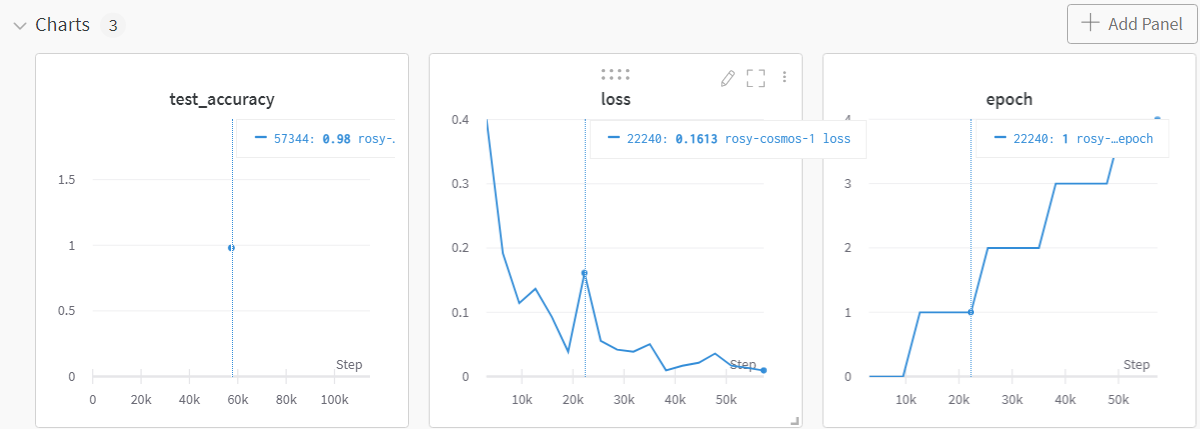

# C - Do keras classifier for regression problem, image problem

In [ ]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
# Perceptrons
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


In [ ]:
y_pred

array([1])

Saving figure perceptron_iris_plot


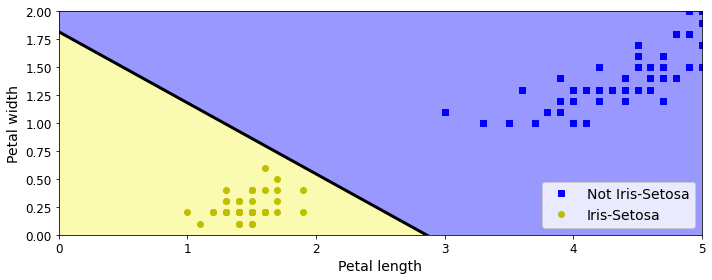

In [ ]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

In [ ]:
# Activation functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Saving figure activation_functions_plot


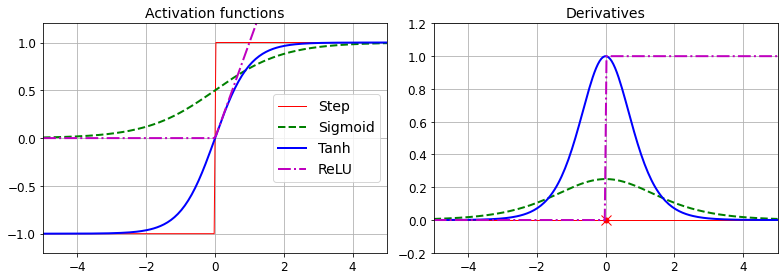

In [ ]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

In [ ]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

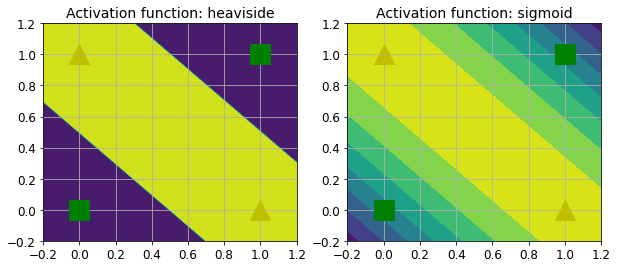

In [ ]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

## Image Classifier

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
X_train_full.shape

(60000, 28, 28)

In [ ]:
X_train_full.dtype

dtype('uint8')

In [ ]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

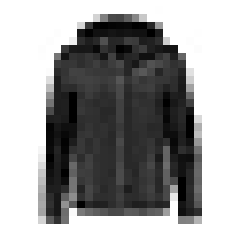

In [ ]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [ ]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [ ]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [ ]:
class_names[y_train[0]]

'Coat'

In [ ]:
X_valid.shape

(5000, 28, 28)

In [ ]:
X_test.shape

(10000, 28, 28)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.layers

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


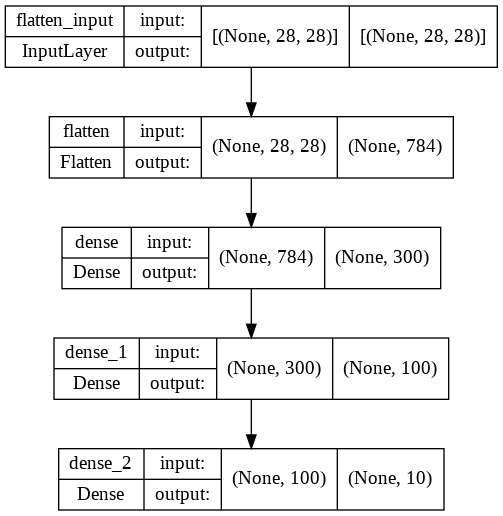

In [ ]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [ ]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [ ]:
model.get_layer(hidden1.name) is hidden1

True

In [ ]:
weights, biases = hidden1.get_weights()

In [ ]:
weights.shape

(784, 300)

In [ ]:
biases.shape

(300,)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 9s 4ms/step - loss: 0.7237 - accuracy: 0.7643 - val_loss: 0.5213 - val_accuracy: 0.8226
Epoch 2/30
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4842 - accuracy: 0.8318 - val_loss: 0.4353 - val_accuracy: 0.8526
Epoch 3/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4391 - accuracy: 0.8457 - val_loss: 0.5333 - val_accuracy: 0.7988
Epoch 4/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4123 - accuracy: 0.8564 - val_loss: 0.3916 - val_accuracy: 0.8650
Epoch 5/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3939 - accuracy: 0.8616 - val_loss: 0.3741 - val_accuracy: 0.8698
Epoch 6/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3751 - accuracy: 0.8678 - val_loss: 0.3706 - val_accuracy: 0.8726
Epoch 7/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3630 - accuracy: 0.8715 - val_loss: 0.3621 - val_accuracy:

In [ ]:
history.params

{'epochs': 30, 'steps': 1719, 'verbose': 1}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Saving figure keras_learning_curves_plot


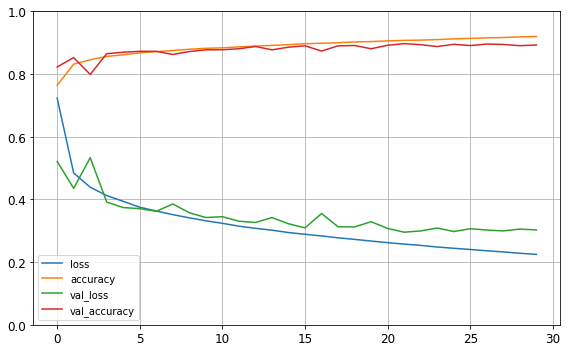

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3366 - accuracy: 0.8820


[0.3366333842277527, 0.8820000290870667]

In [ ]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.96],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [ ]:
#y_pred = model.predict_classes(X_new) # deprecated
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

array([9, 2, 1])

In [ ]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [ ]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Saving figure fashion_mnist_images_plot


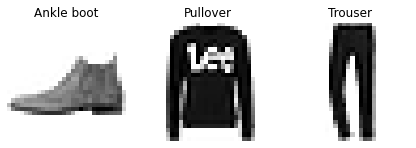

In [ ]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

## Regression MLP

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.6419 - val_loss: 0.8560
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7047 - val_loss: 0.6531
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6345 - val_loss: 0.6099
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5977 - val_loss: 0.5658
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5706 - val_loss: 0.5355
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5472 - val_loss: 0.5173
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5288 - val_loss: 0.5081
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5130 - val_loss: 0.4799
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4992 - val_loss: 0.4690
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4875 - val_loss: 0.4656

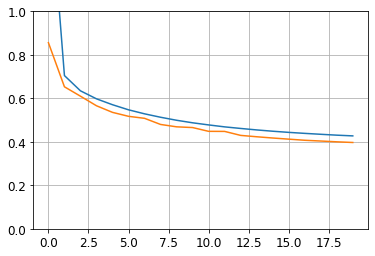

In [ ]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
y_pred

array([[0.38856643],
       [1.6792021 ],
       [3.1022797 ]], dtype=float32)

# D - use of various activation functions, dropouts, learning rate schedulers , regularization techniques like gradient clipping, batch normalization, early stopping, l1 and l2 regularizations, optimizers on simple data set

Reference: https://github.com/ageron/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb 

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [ ]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [ ]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4431872/4422102 [==============================] - 0s 0us/step


**a neural network on Fashion MNIST using the Leaky ReLU:**

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 12s 5ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.7955 - accuracy: 0.7362 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7900
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8066
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5832 - accuracy: 0.8074 - val_loss: 0.5582 - val_accuracy: 0.8202
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5553 - accuracy: 0.8157 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5338 - accuracy: 0.8225 - val_loss: 0.5157 - val_accura

**Batch Normalization**

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_5 (Dense)             (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)             

In [ ]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 12s 5ms/step - loss: 0.8293 - accuracy: 0.7221 - val_loss: 0.5539 - val_accuracy: 0.8156
Epoch 2/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5703 - accuracy: 0.8036 - val_loss: 0.4792 - val_accuracy: 0.8378
Epoch 3/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.5161 - accuracy: 0.8214 - val_loss: 0.4425 - val_accuracy: 0.8496
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4789 - accuracy: 0.8315 - val_loss: 0.4213 - val_accuracy: 0.8562
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4548 - accuracy: 0.8405 - val_loss: 0.4052 - val_accuracy: 0.8612
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4387 - accuracy: 0.8445 - val_loss: 0.3932 - val_accuracy: 0.8634
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4255 - accuracy: 0.8504 - val_loss: 0.3830 - val_accura

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 1.0346 - accuracy: 0.6739 - val_loss: 0.6680 - val_accuracy: 0.7884
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.6757 - accuracy: 0.7819 - val_loss: 0.5537 - val_accuracy: 0.8212
Epoch 3/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.5961 - accuracy: 0.8021 - val_loss: 0.4996 - val_accuracy: 0.8352
Epoch 4/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.5456 - accuracy: 0.8176 - val_loss: 0.4655 - val_accuracy: 0.8458
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5140 - accuracy: 0.8250 - val_loss: 0.4419 - val_accuracy: 0.8510
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4915 - accuracy: 0.8309 - val_loss: 0.4237 - val_accuracy: 0.8540
Epoch 7/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.4741 - accuracy: 0.8375 - val_loss: 0.4103 - val_accur

**Reusing Pretrained Layers**

In [ ]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [ ]:
X_train_A.shape

(43986, 28, 28)

In [ ]:
X_train_B.shape

(200, 28, 28)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [ ]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [ ]:
history = model_A.fit(X_train_A, y_train_A, epochs=10,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/10
1375/1375 [==============================] - 8s 5ms/step - loss: 0.5926 - accuracy: 0.8104 - val_loss: 0.3896 - val_accuracy: 0.8662
Epoch 2/10
1375/1375 [==============================] - 6s 4ms/step - loss: 0.3523 - accuracy: 0.8785 - val_loss: 0.3288 - val_accuracy: 0.8824
Epoch 3/10
1375/1375 [==============================] - 8s 6ms/step - loss: 0.3171 - accuracy: 0.8896 - val_loss: 0.3013 - val_accuracy: 0.8981
Epoch 4/10
1375/1375 [==============================] - 7s 5ms/step - loss: 0.2973 - accuracy: 0.8974 - val_loss: 0.2894 - val_accuracy: 0.9021
Epoch 5/10
1375/1375 [==============================] - 7s 5ms/step - loss: 0.2835 - accuracy: 0.9021 - val_loss: 0.2775 - val_accuracy: 0.9063
Epoch 6/10
1375/1375 [==============================] - 7s 5ms/step - loss: 0.2730 - accuracy: 0.9062 - val_loss: 0.2730 - val_accuracy: 0.9066
Epoch 7/10
1375/1375 [==============================] - 6s 4ms/step - loss: 0.2641 - accuracy: 0.9092 - val_loss: 0.2718 - val_accuracy:

In [ ]:
# save the model
model_A.save("my_model_A.h5")

In [ ]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [ ]:
history = model_B.fit(X_train_B, y_train_B, epochs=10,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/10
7/7 [==============================] - 2s 85ms/step - loss: 0.9573 - accuracy: 0.4650 - val_loss: 0.6314 - val_accuracy: 0.6004
Epoch 2/10
7/7 [==============================] - 0s 35ms/step - loss: 0.5692 - accuracy: 0.7450 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/10
7/7 [==============================] - 0s 30ms/step - loss: 0.4503 - accuracy: 0.8650 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/10
7/7 [==============================] - 0s 30ms/step - loss: 0.3879 - accuracy: 0.8950 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/10
7/7 [==============================] - 0s 35ms/step - loss: 0.3435 - accuracy: 0.9250 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/10
7/7 [==============================] - 0s 36ms/step - loss: 0.3081 - accuracy: 0.9300 - val_loss: 0.3019 - val_accuracy: 0.9402
Epoch 7/10
7/7 [==============================] - 0s 35ms/step - loss: 0.2800 - accuracy: 0.9350 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/10
7/7 [===========

In [ ]:
model_B.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_17 (Dense)            (None, 300)               235500    
                                                                 
 dense_18 (Dense)            (None, 100)               30100     
                                                                 
 dense_19 (Dense)            (None, 50)                5050      
                                                                 
 dense_20 (Dense)            (None, 50)                2550      
                                                                 
 dense_21 (Dense)            (None, 50)                2550      
                                                                 
 dense_22 (Dense)            (None, 1)                

In [ ]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

In [ ]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=10,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 79ms/step - loss: 0.2831 - accuracy: 0.9050 - val_loss: 0.2996 - val_accuracy: 0.9118
Epoch 2/4
7/7 [==============================] - 0s 35ms/step - loss: 0.2733 - accuracy: 0.9250 - val_loss: 0.2899 - val_accuracy: 0.9178
Epoch 3/4
7/7 [==============================] - 0s 35ms/step - loss: 0.2637 - accuracy: 0.9300 - val_loss: 0.2810 - val_accuracy: 0.9239
Epoch 4/4
7/7 [==============================] - 0s 33ms/step - loss: 0.2550 - accuracy: 0.9450 - val_loss: 0.2728 - val_accuracy: 0.9270
Epoch 1/10
7/7 [==============================] - 1s 75ms/step - loss: 0.2281 - accuracy: 0.9450 - val_loss: 0.2201 - val_accuracy: 0.9554
Epoch 2/10
7/7 [==============================] - 0s 31ms/step - loss: 0.1819 - accuracy: 0.9500 - val_loss: 0.1845 - val_accuracy: 0.9716
Epoch 3/10
7/7 [==============================] - 0s 31ms/step - loss: 0.1505 - accuracy: 0.9650 - val_loss: 0.1597 - val_accuracy: 0.9787
Epoch 4/10
7/7 [===============

In [ ]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 5ms/step - loss: 0.2265 - accuracy: 0.9580


[0.22645285725593567, 0.9580000042915344]

In [ ]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 5ms/step - loss: 0.0805 - accuracy: 0.9910


[0.08052635192871094, 0.9909999966621399]

**Optimizers & Learning Rate Scheduling**

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [ ]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4919 - accuracy: 0.8263 - val_loss: 0.4029 - val_accuracy: 0.8606
Epoch 2/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3810 - accuracy: 0.8640 - val_loss: 0.3728 - val_accuracy: 0.8728
Epoch 3/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3483 - accuracy: 0.8762 - val_loss: 0.3731 - val_accuracy: 0.8690
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3273 - accuracy: 0.8830 - val_loss: 0.3508 - val_accuracy: 0.8768
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3122 - accuracy: 0.8888 - val_loss: 0.3452 - val_accuracy: 0.8756
Epoch 6/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2986 - accuracy: 0.8935 - val_loss: 0.3428 - val_accuracy: 0.8824
Epoch 7/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2887 - accuracy: 0.8979 - val_loss: 0.3373 - val_accuracy:

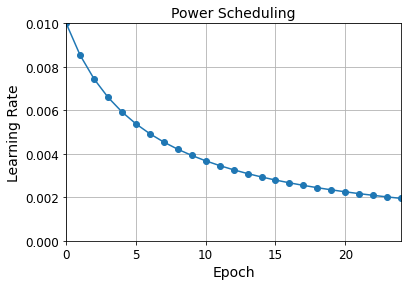

In [ ]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

**Exponential Scheduling**

In [ ]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 12s 6ms/step - loss: 0.8780 - accuracy: 0.7476 - val_loss: 0.8024 - val_accuracy: 0.7482 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.6970 - accuracy: 0.7863 - val_loss: 0.6898 - val_accuracy: 0.8116 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6269 - accuracy: 0.8061 - val_loss: 0.8295 - val_accuracy: 0.7760 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5705 - accuracy: 0.8258 - val_loss: 0.4982 - val_accuracy: 0.8446 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5021 - accuracy: 0.8434 - val_loss: 0.5216 - val_accuracy: 0.8508 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4771 - accuracy: 0.8508 - val_loss: 0.4828 - val_accuracy: 0.8560 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] - 

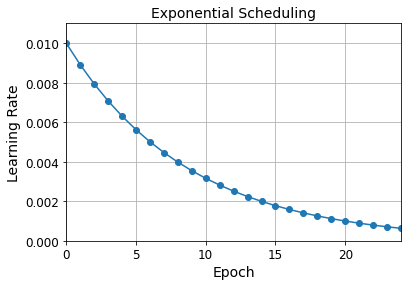

In [ ]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

**L1&L2 regularization**

In [ ]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor of 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 10s 5ms/step - loss: 1.6106 - accuracy: 0.8115 - val_loss: 0.7174 - val_accuracy: 0.8300
Epoch 2/2
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7182 - accuracy: 0.8277 - val_loss: 0.6807 - val_accuracy: 0.8394


In [ ]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 10s 6ms/step - loss: 1.6600 - accuracy: 0.8123 - val_loss: 0.7201 - val_accuracy: 0.8336
Epoch 2/2
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7232 - accuracy: 0.8272 - val_loss: 0.6848 - val_accuracy: 0.8392


**Dropout**

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 10s 5ms/step - loss: 0.5761 - accuracy: 0.8037 - val_loss: 0.3816 - val_accuracy: 0.8612
Epoch 2/2
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4190 - accuracy: 0.8461 - val_loss: 0.3466 - val_accuracy: 0.8700
